In [1]:
import sys
sys.path.append('../src')

In [2]:
from metrics import calculate_false_alarm, calculate_delay, calculate_precision, compute_metrics
from loading import *
from visualization import *
from features import *
from helpers import *

from matplotlib import pyplot as plt
%matplotlib inline

# Extract metrics for feature according to threshold value

In [3]:
data_path = "../data/"
patient_data = load_patient_seizures(data_path, 1,all_seizures=True, delta=1)

Seizure starts (s):  [[ 432362.43824219]
 [1029684.37003906]]
Seizure ends (s):  [[ 432976.20269531]
 [1030274.18042969]]
Duration (s):  [[613.76445313]
 [589.81039063]]
Sampled frequency (Hz):  512
Start/end [432362.43824219] [432976.20269531]
Start/end [1029684.37003906] [1030274.18042969]
EEG files:  [['../data/ID01/ID01_120h.mat', '../data/ID01/ID01_121h.mat', '../data/ID01/ID01_122h.mat'], ['../data/ID01/ID01_286h.mat', '../data/ID01/ID01_287h.mat', '../data/ID01/ID01_288h.mat']]
Hour of seizure:  [array([120, 121, 122]), array([286, 287, 288])]
Samples ranges:  [(185568, 499815), (43197, 345180)]


In [4]:
eegs = patient_data['eegs']
ranges = patient_data['ranges']
seizure_start_s = patient_data["infos"]["seizure_start"]
seizure_end_s = patient_data["infos"]["seizure_end"] 

In [5]:
max_power_eeg = top_signals(eegs, ranges, top=1, id_seizure = None)

## Convert seizure sample ranges into sliding window ranges

In [6]:
window_size = 128
step_size = 64

In [7]:
indexes = convert_sample_ranges_to_window_ranges(ranges,window_size,step_size,1843200)

# Computing signal energy with window

In [8]:
energy_feature_signals = calculate_feature(eegs, max_power_eeg[0], window_size, step_size, calculate_energy)

## Plotting the obtained signals

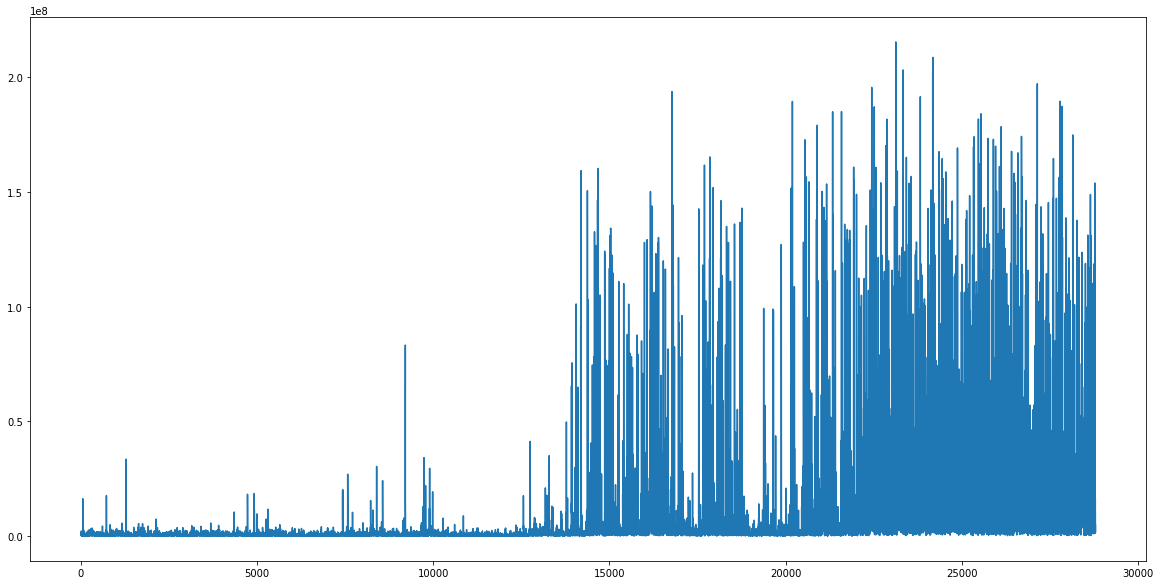

In [9]:
plt.figure(figsize=(20,10))
plt.plot(energy_feature_signals[0][0])

time 9910
data 28799


[]

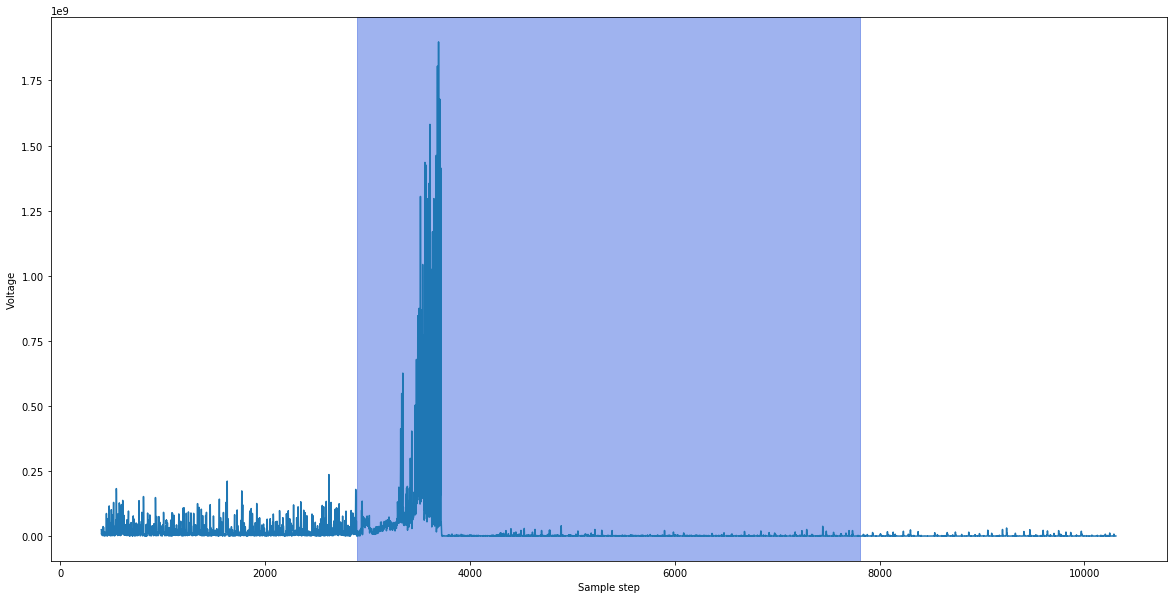

In [10]:
plot_one_signal(energy_feature_signals[0][1] , indexes, 5000, seizure_id=0)

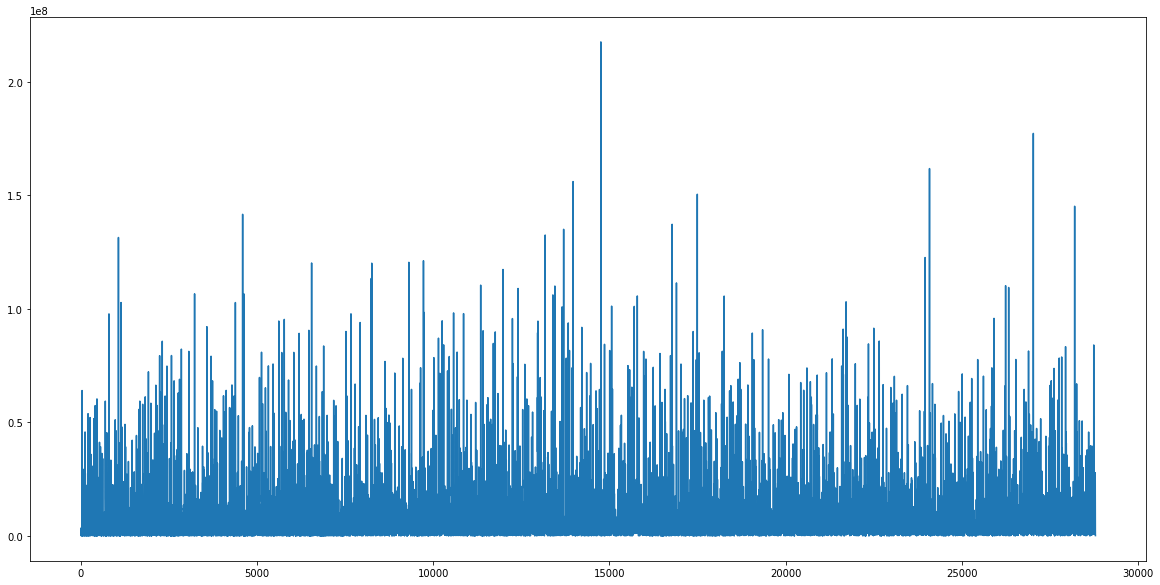

In [11]:
plt.figure(figsize=(20,10))
plt.plot(energy_feature_signals[0][2])

# Merging arrays of multiple files

In [12]:
seizures_window_ranges, seizures_data = merge_seizures_data(energy_feature_signals, indexes)

In [13]:
all_data_window_ranges, all_data = merge_all_data(energy_feature_signals, indexes)

## Plotting the results

### First seizure result

time 14910
data 86397


[]

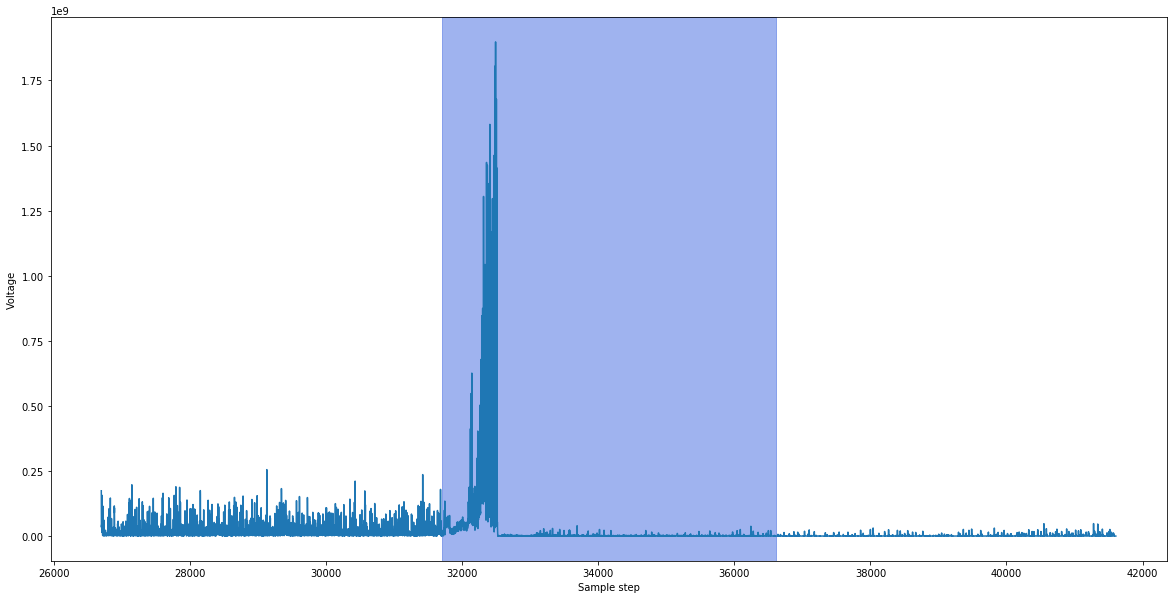

In [14]:
plot_one_signal(seizures_data[0] , seizures_window_ranges, 10000, seizure_id=0)

### Second seizure results

time 14719
data 86397


[]

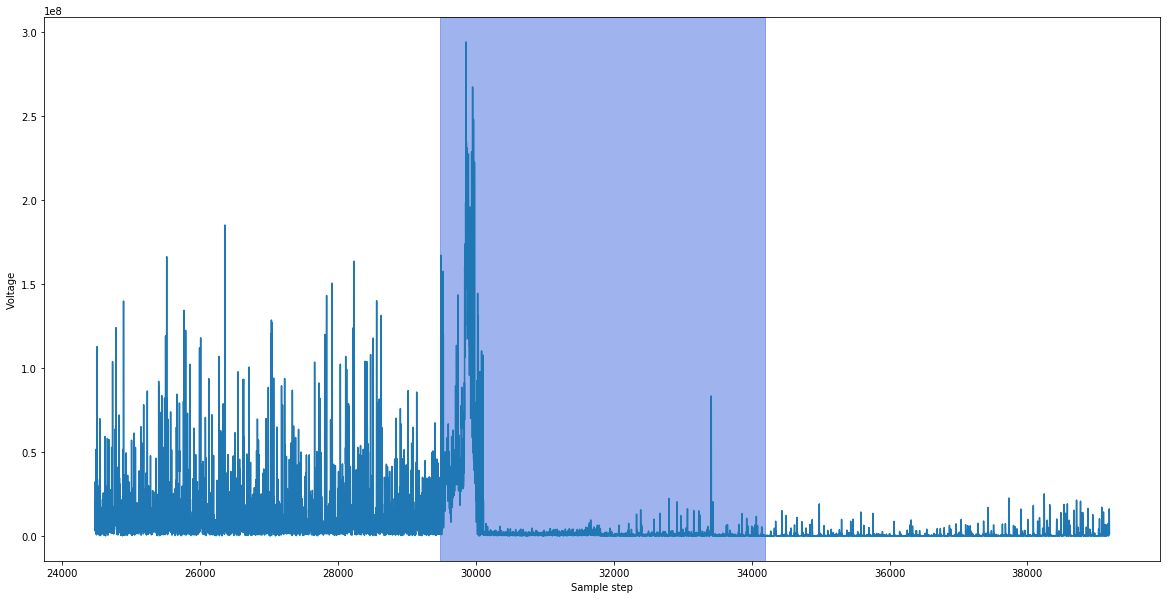

In [15]:
plot_one_signal(seizures_data[1] , seizures_window_ranges, 10000, seizure_id=1)

### All seizures result

time 98891
data 172794


[]

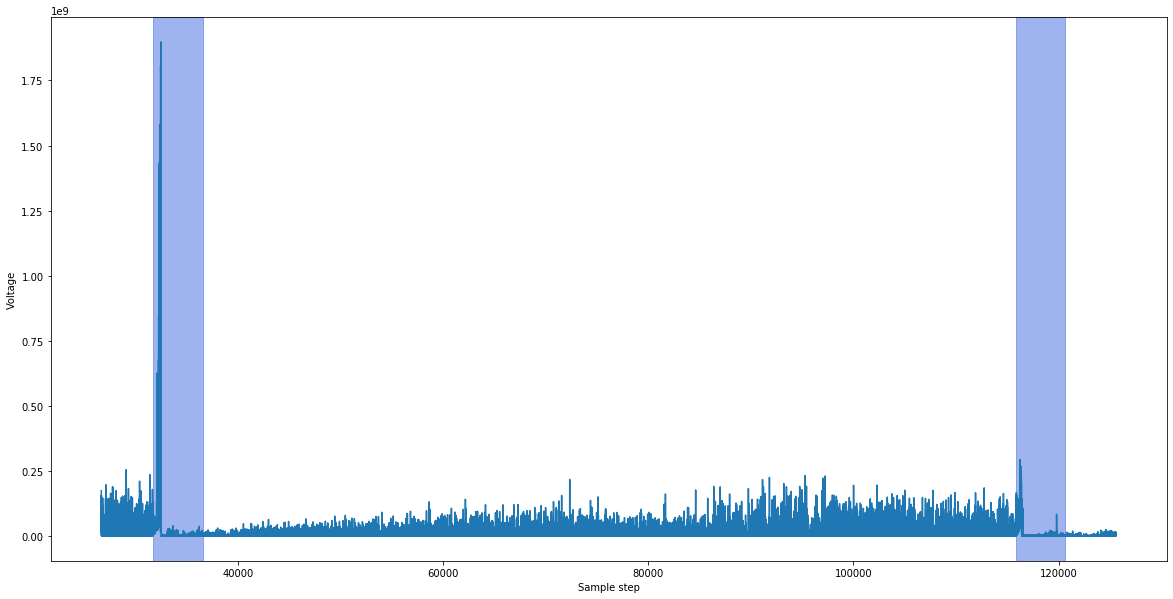

In [16]:
plot_one_signal(all_data , all_data_window_ranges, 10000)

# Plotting real signal and computed energy signal

In [17]:
energy_seizure1_single = energy_feature_signals[0][1]
energy_seizure1_single_scaled = scale_signal(energy_seizure1_single, 128, 64)

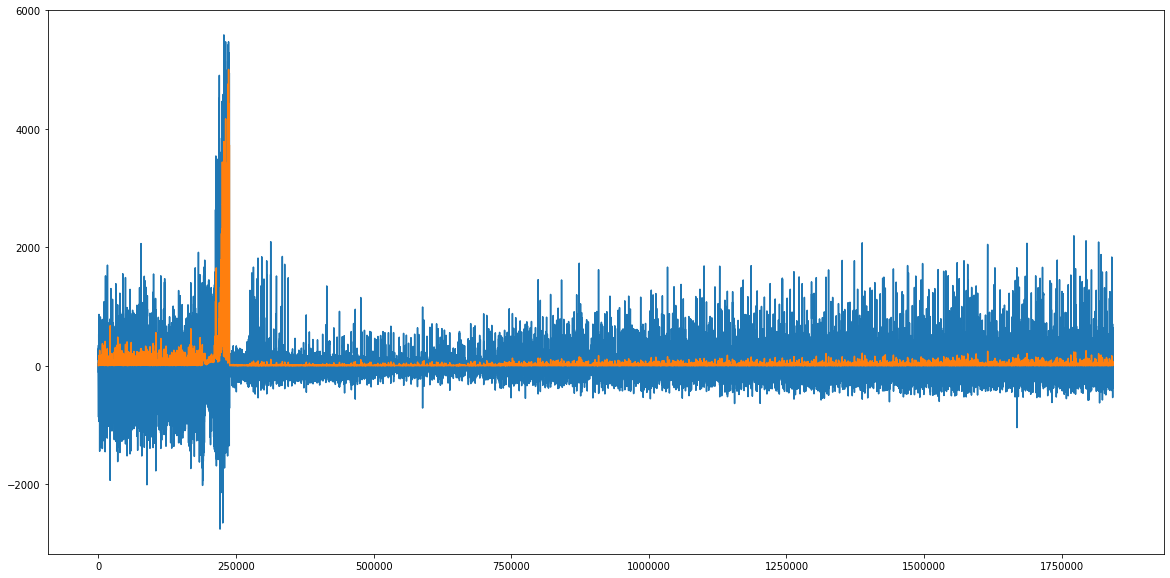

In [18]:
plt.figure(figsize=(20,10))
plt.plot(eegs[0][1][max_power_eeg].T)
plt.plot(energy_seizure1_single_scaled/np.max(energy_seizure1_single_scaled)*5000)

# Calculate metrics according to the threshold value

## Calculate False Alarm

False alarms are calculated by:
* removing the part of the signal where the seizure occurs (we won't find false alarm here)
* Rescaling the signal values between 0 and 1
* Counting the number of elements (1) in the list generated by np.where (a value of this list is equal to one if the corresponding signal value is superior or equal to the threshold

## Calculate Delay

## Calculate precision

# Plotting the functions

In [19]:
thresholds, false_alarms, delays, precisions = compute_metrics(all_data, all_data_window_ranges, window_size, step_size)

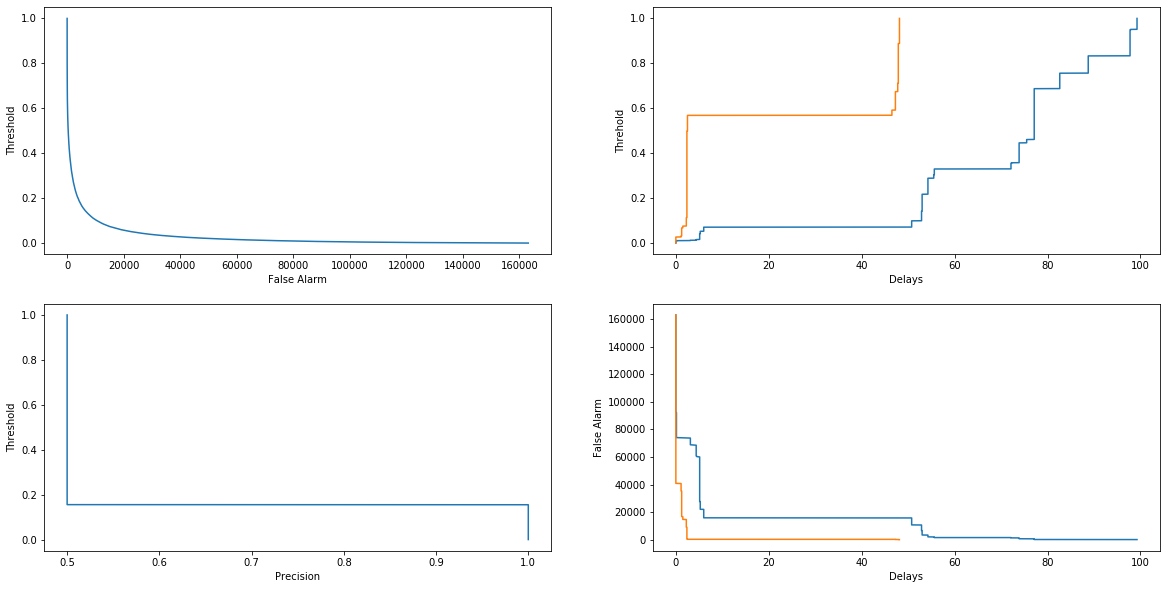

In [20]:
plt_all_metrics = plot_metrics(thresholds, false_alarms, delays, precisions)

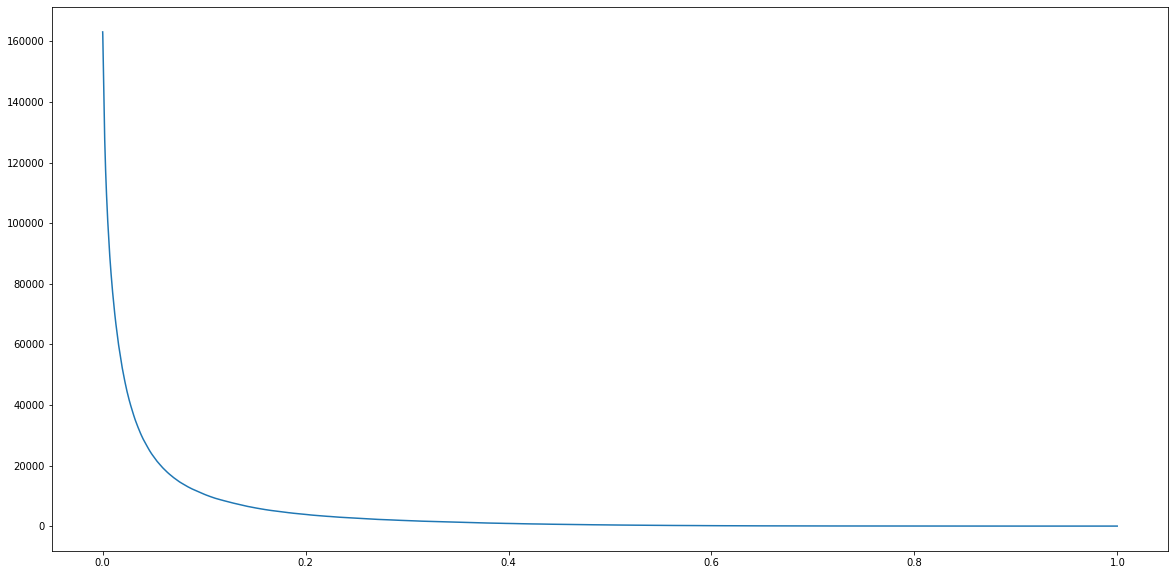

In [21]:
plt.figure(figsize=(20,10))
plt.plot(thresholds, false_alarms)

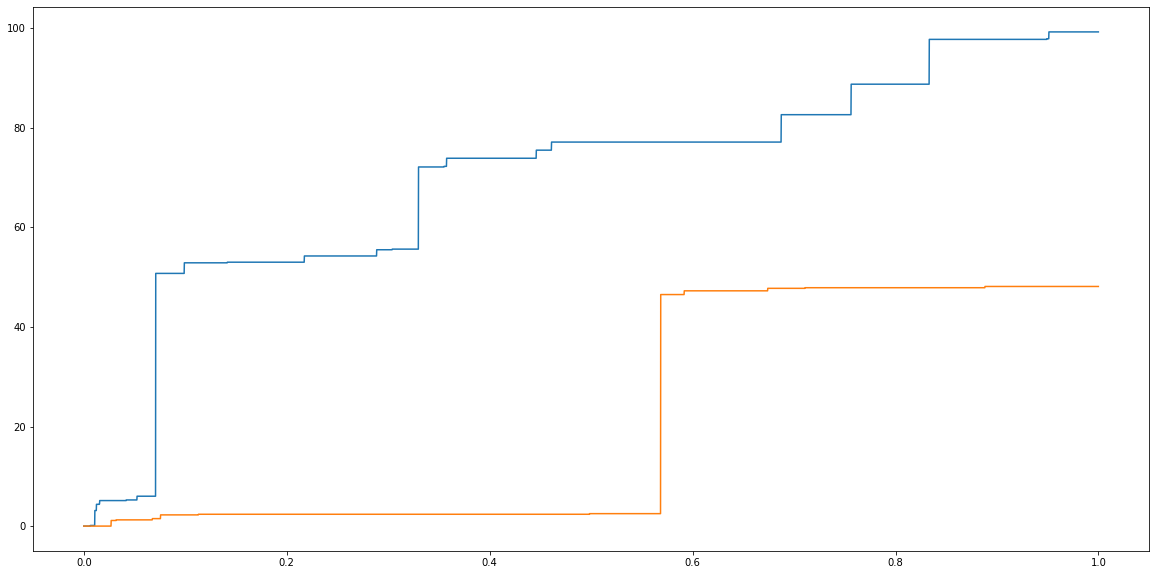

In [22]:
plt.figure(figsize=(20,10))
for i in range(len(delays[0])):
    plt.plot(thresholds, [pt[i] for pt in delays],label = 'seizure %s'%i)
plt.show()

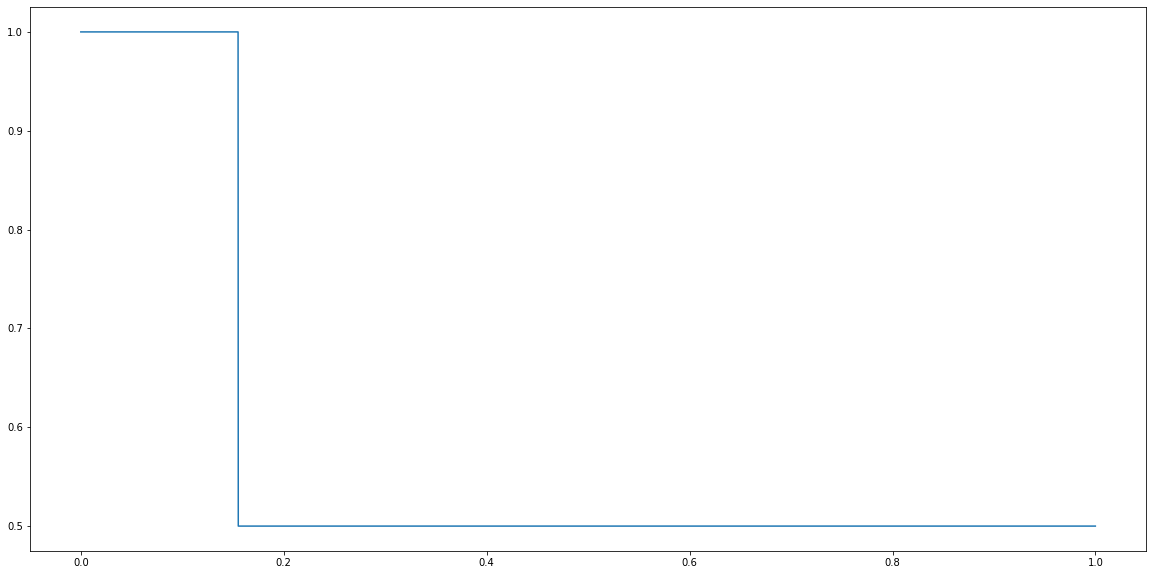

In [23]:
plt.figure(figsize=(20,10))
plt.plot(thresholds, precisions)
plt.show()

# Select best threshold and compute the score of the feature for seizures

The goal is to find a way to calculate the best threshold according to several constrains:

* The delay should be <  $D_max$ and as lower as possible
* The false alarm rate should be as lower as possible
* The precision should be equal to 1


In [24]:
def plot_scores(thresholds, scores):
    plt.figure(figsize=(20,10))
    for i,score in enumerate(scores):
        plt.plot(thresholds,score, label = 'seizure {}'.format(i))
    plt.legend()
    plt.show()

## 1st method

We simply compute: $(w_1 * D) * (w_2 * FA) * (w_3 * P)$

In [25]:
weights = (1,1,1)
lambda_ = 0.00001
d_max = 10

In [26]:
def compute_score_1(threshold, false_alarm, precision, delay, weights, lambda_=0.00001, d_max=10):
    all_scores = []
    w1, w2, w3 = weights
    
    # Compute min and max values of false alarm rate and delay
    min_false_alarm = min(false_alarm)
    max_false_alarm = max(false_alarm)
    
    delay_list = list(zip(*delay))
    min_delay = min([min(d) for d in delay_list])
    max_delay = max([max(d) for d in delay_list])
    
    for seizure in range(len(delay_list)):
        
        # Normalize delay and false alarms
        delays_i = np.array(delay_list[seizure])
        min_delay = min(delays_i)
        max_delay = max(delays_i)
        normalized_delays = (delays_i - min_delay) / (max_delay - min_delay)
        min_false_alarm = min(false_alarm)
        max_false_alarm = max(false_alarm)
        normalized_false_alarms = (np.array(false_alarm) - min_false_alarm) / (max_false_alarm - min_false_alarm)
        
        # Compute score
        scores = (w1*normalized_delays) * (w2*normalized_false_alarms) * (w3*np.array(precision))
        
        # Adding constrains
        scores = np.where(np.array(delays_i)>d_max, 0, scores)
        all_scores.append(scores)
        
        # Printing best score threshold and metrics
        max_score = np.max(scores)
        index_max_score = np.argmax(scores)
        best_threshold = threshold[index_max_score]

        print("Max score for seizure {} is {} for t={}".format(seizure, max_score, best_threshold))
        print("FA:", false_alarm[index_max_score])
        print("Delay:", delay[index_max_score][seizure])
        print("Precision:", precision[index_max_score])
        print()
    return all_scores

In [27]:
scores_1 = compute_score_1(thresholds, false_alarms, precisions, delays, weights)

Max score for seizure 0 is 0.018994812099547568 for t=0.015600000000000001
FA: 60021
Delay: 5.1251779575679715
Precision: 1.0

Max score for seizure 1 is 0.005830831667413266 for t=0.0269
FA: 40699
Delay: 1.1250390638563839
Precision: 1.0



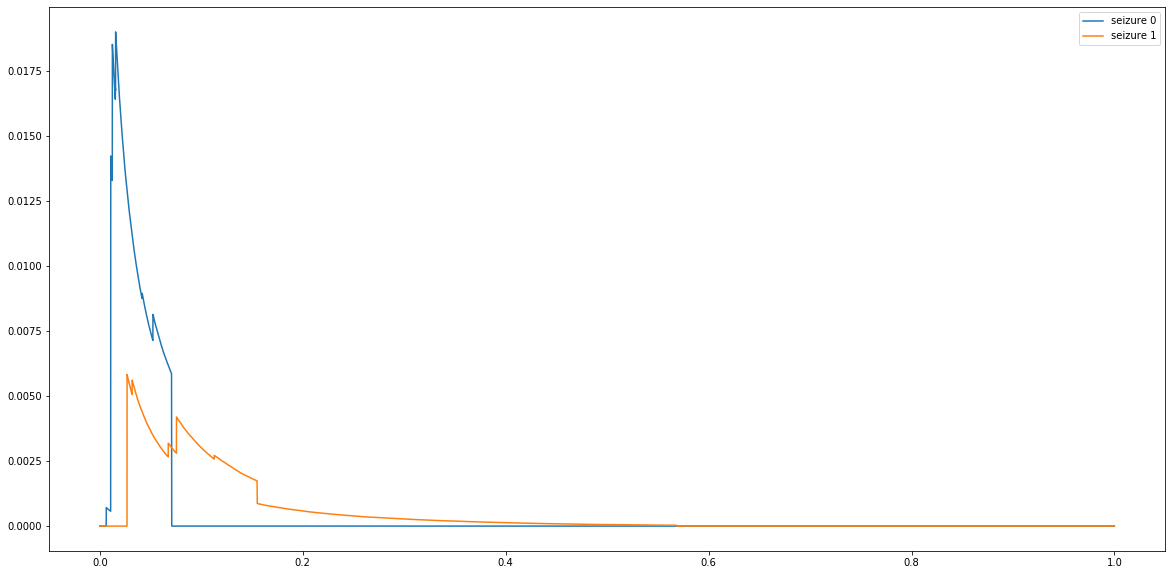

In [28]:
plot_scores(thresholds, scores_1)

## 2nd method (Norm 1 inverse)

We compute the inverse of the norm 1 : $\|(x, y, z)\| = x + y + z$

With $x = w_1 * FA$, $y = w_2 * D$, $z = w_3 * 1/P$

$$\frac{1}{FA+D+1}$$

Remarks:

* $\lambda$ is a small number avoiding division by zero
* We consider that each point in a 3-D coordinates point in the space of False Alarm, Delay and Precision for a given threshold value
* FA and D are normalised before the computation of the score
* We enforce the Delay to be inferior to $D_{max}$
* $w_1, w_2, w_3$ are wights that can be defined to give more importance of some metrics upon others


In [29]:
weights = (1,1,1)
lambda_ = 0.00001
d_max = 10

In [30]:
def compute_score_2(threshold, false_alarm, precision, delay, weights, lambda_=0.00001, d_max=10):
    all_scores = []
    w1, w2, w3 = weights
    
    # Compute min and max values of false alarm rate and delay
    min_false_alarm = min(false_alarm)
    max_false_alarm = max(false_alarm)
    
    delay_list = list(zip(*delay))
    min_delay = min([min(d) for d in delay_list])
    max_delay = max([max(d) for d in delay_list])
    
    for seizure in range(len(delay_list)):
        
        # Normalize delay and false alarms
        delays_i = np.array(delay_list[seizure])

        normalized_delays = (delays_i - min_delay) / (max_delay - min_delay)
        normalized_false_alarms = (np.array(false_alarm) - min_false_alarm) / (max_false_alarm - min_false_alarm)
        
        # Compute score
        scores = 1/((w1*normalized_delays) + (w2*normalized_false_alarms) + 1/(w3*np.array(precision)) + lambda_)
        
        # Adding constrains
        scores = np.where(np.array(delays_i)>d_max, 0, scores)
        all_scores.append(scores)
        
        # Printing best score threshold and metrics
        max_score = np.max(scores)
        index_max_score = np.argmax(scores)
        best_threshold = threshold[index_max_score]

        print("Max score for seizure {} is {} for t={}".format(seizure, max_score, best_threshold))
        print("FA:", false_alarm[index_max_score])
        print("Delay:", delay[index_max_score][seizure])
        print("Precision:", precision[index_max_score])
        print()
    return all_scores

In [31]:
scores_2 = compute_score_2(thresholds, false_alarms, precisions, delays, weights)

Max score for seizure 0 is 0.8640721646644873 for t=0.0707
FA: 15803
Delay: 6.000208340567381
Precision: 1.0

Max score for seizure 1 is 0.9441647531739001 for t=0.155
FA: 5744
Delay: 2.375082468141255
Precision: 1.0



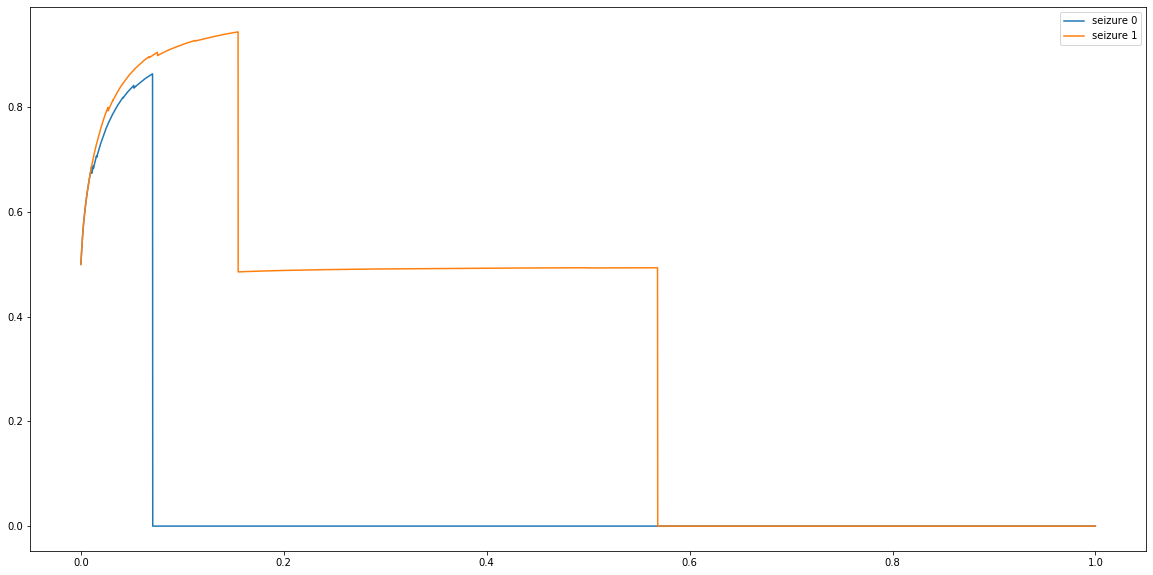

In [32]:
plot_scores(thresholds, scores_2)

## 3rd method (Norm 2 inverse)

We compute the inverse of the norm 2 : $\|(x,y,z)\|^2 = \sqrt{x^2 + y^2 + z^2}$.

With $x = w_1 * FA$, $y = w_2 * D$, $z = w_3 * 1/P$

$$\frac{1}{\sqrt{(w_1 * FA)^2+ (w_2 * D)^2+ \frac{1}{(w_3 * P)^2} + \lambda}}$$

Remarks:

* $\lambda$ is a small number avoiding division by zero
* We consider that each point in a 3-D coordinates point in the space of False Alarm, Delay and Precision for a given threshold value
* FA and D are normalised before the computation of the score
* We enforce the Delay to be inferior to $D_{max}$
* $w_1, w_2, w_3$ are wights that can be defined to give more importance of some metrics upon others


In [33]:
weights = (1,1,1)
lambda_ = 0.00001
d_max = 10

In [34]:
def compute_score_3(threshold, false_alarm, precision, delay, weights, lambda_=0.00001, d_max=10):
    all_scores = []
    w1, w2, w3 = weights
    
    # Compute min and max values of false alarm rate and delay
    min_false_alarm = min(false_alarm)
    max_false_alarm = max(false_alarm)
    
    delay_list = list(zip(*delay))
    min_delay = min([min(d) for d in delay_list])
    max_delay = max([max(d) for d in delay_list])
    
    for seizure in range(len(delay_list)):
        
        # Normalize delay and false alarms
        delays_i = np.array(delay_list[seizure])

        normalized_delays = (delays_i - min_delay) / (max_delay - min_delay)
        normalized_false_alarms = (np.array(false_alarm) - min_false_alarm) / (max_false_alarm - min_false_alarm)
        
        # Compute score
        scores = 1/(np.sqrt((w1*normalized_delays)**2 + (w2*normalized_false_alarms)**2 + 1/(w3*np.array(precision)**2) + lambda_))
        
        # Adding constrains
        scores = np.where(np.array(delays_i)>d_max, 0, scores)
        all_scores.append(scores)
        
        # Printing best score threshold and metrics
        max_score = np.max(scores)
        index_max_score = np.argmax(scores)
        best_threshold = threshold[index_max_score]

        print("Max score for seizure {} is {} for t={}".format(seizure, max_score, best_threshold))
        print("FA:", false_alarm[index_max_score])
        print("Delay:", delay[index_max_score][seizure])
        print("Precision:", precision[index_max_score])
        print()
    return all_scores

In [35]:
scores_3 = compute_score_3(thresholds, false_alarms, precisions, delays, weights)

Max score for seizure 0 is 0.9935411083863654 for t=0.0707
FA: 15803
Delay: 6.000208340567381
Precision: 1.0

Max score for seizure 1 is 0.9990904929420596 for t=0.155
FA: 5744
Delay: 2.375082468141255
Precision: 1.0



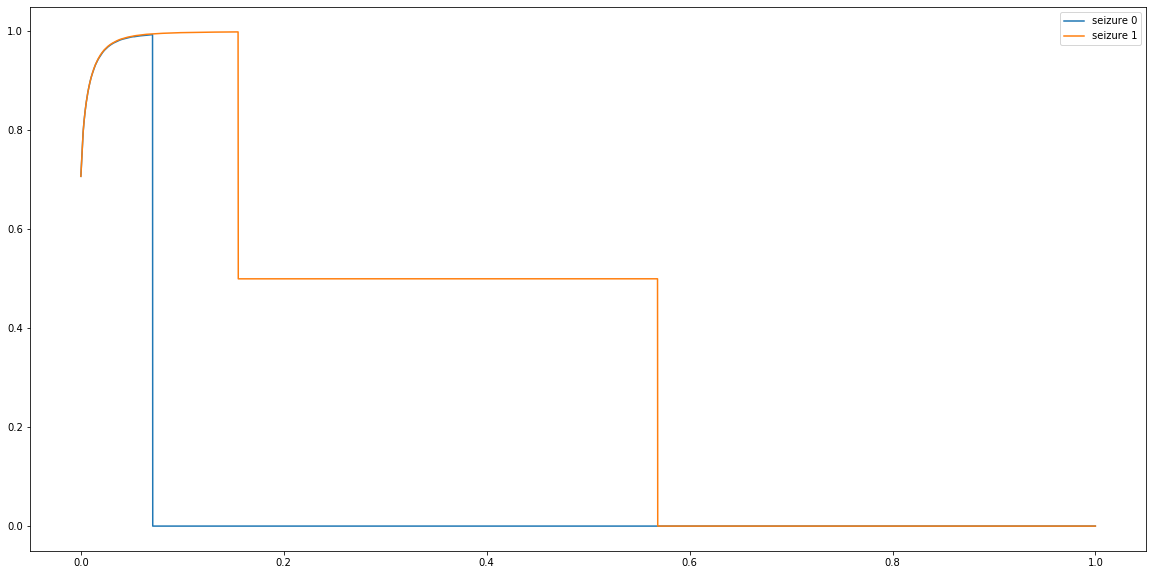

In [36]:
plot_scores(thresholds, scores_3)

# Calculate overall score of a feature for a given patient

In addition to the previous scores calculated, we also need to quantify how good is feature compared with other features on a specific patient.
To achieve this, we need to define a score that :

* Is higher when we minimize the FA and the delays
* Is higher when threshold values are close to each others
* Is higher when both previous conditions are met


The overall score is computed by:
* **We first want to know if the scores are close to each others for a given patient**: We measure the distance between all score points in a 2-D space $[(max_{score_1}, t_1), (max_{score_2}, t_2), ...]$. This distance is computed using the `euclidian` norm (norm 2) and than we average the distances.
* **We also need to know the avg score of the feature regarding to our metrics (the higher the score is, the better our metrics are)**: We average the previous calculated scores of each seizure.
* Finally, the overall score is obtained by multiplying the averaged scores of our seizure and the inverse average distance of all our scores (we take the inverse as a small distance should result in a good score wheras a big distance should result to a low score)


In [37]:
from scipy.spatial import distance

def overall_score(threshold, scores):
    seizure_scores = []
    feature_overall_score = 0
    
    # Measure distances between points
    for score in scores:
        max_score = np.max(score)
        index_max_score = np.argmax(score)
        best_threshold = threshold[index_max_score]
        seizure_scores.append((max_score, best_threshold))
    
    matrix_distances = distance.cdist(seizure_scores, seizure_scores, 'euclidean')
    distance_score = np.triu(matrix_distances).sum()/matrix_distances.shape[0]
    
    # Compute seizures scores average
    seizure_scores_values = [score[0] for score in seizure_scores]
    n_values = len(seizure_scores_values)
    seizures_overall_score = sum(seizure_scores_values)/n_values
    
    feature_overall_score = seizures_overall_score / distance_score
    print("Distance score", distance_score)
    print("Averaged seizures score", seizures_overall_score)
    print("Overall score", feature_overall_score)

In [38]:
overall_score(thresholds, scores_1)

Distance score 0.008674393074123612
Averaged seizures score 0.012412821883480417
Overall score 1.4309729542357064


In [39]:
overall_score(thresholds, scores_2)

Distance score 0.058140589810686746
Averaged seizures score 0.9041184589191937
Overall score 15.550555332567487


In [40]:
overall_score(thresholds, scores_3)

Distance score 0.04224122887933949
Averaged seizures score 0.9963158006642125
Overall score 23.586335603780654
